## Allociné SQUIDGAMES
# Etude portée sur les commentaires des téléspectateurs

# 18-02-2021

# Les objectifs de ce Projet sont :


1.   Mettre en place Naive Bayes sur une cible binaire
2.   Faire apprendre votre algo sur l'échantillon de train

1.   Faire votre prédiction sur le test
2.   Comparer les résultats avec l'approche de règles

1.   Mettre en place Naive Bayes sur les notes en générale








## Drive


In [ ]:
import os
from google.colab import drive
drive.mount('drive/')

Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/NLP')

## Importation

In [ ]:
!pip install dateparser
!pip install scattertext

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import dateparser
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn import metrics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('allocine_squidgame.csv')

In [ ]:
df.head()

,Note,Description,Date,nombre_good,nombre_follow,key
0,"3,0","On s'attendait à une fin plus élaborée, claire...",Publiée le 2 octobre 2021,22\n\n\n10,Suivre son activité,0
1,"2,5",Encore une série très sur-côtée ! Tout est pré...,Publiée le 1 octobre 2021,24\n\n\n12,Suivre son activité,1
2,"4,5",Pas fan des séries coréennes en général. Je do...,Publiée le 22 septembre 2021,20\n\n\n21,Suivre son activité,2
3,"4,5","Disons le tout de suite, je suis fan depuis 30...",Publiée le 5 octobre 2021,9\n\n\n10,Suivre son activité,3
4,"4,0","Visuellement recherché, très ludique, rythmé e...",Publiée le 25 septembre 2021,7\n\n\n\n9,Suivre son activité,4


## Nettoyage

In [ ]:
df['nombre_follow'].value_counts()

Suivre son activité    341
Name: nombre_follow, dtype: int64

In [ ]:
df.drop(['nombre_follow','key'], axis=1, inplace=True)

In [ ]:
df['Note'].describe()

count     341
unique     10
top       5,0
freq       72
Name: Note, dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Note         341 non-null    object
 1   Description  341 non-null    object
 2   Date         341 non-null    object
 3   nombre_good  341 non-null    object
dtypes: object(4)
memory usage: 10.8+ KB


In [ ]:
df['good'] = df.nombre_good.apply(lambda x: re.split("\s+", x)[0])
df['bad'] = df.nombre_good.apply(lambda x: re.split("\s+", x)[1])
df.drop('nombre_good', axis=1, inplace=True)

In [ ]:
df['Note'] = df['Note'].apply(lambda x: re.sub(",",'.',x))
df['Note'] = df['Note'].astype('float')

In [ ]:
df.head()

,Note,Description,Date,good,bad
0,3.0,"On s'attendait à une fin plus élaborée, claire...",Publiée le 2 octobre 2021,22,10
1,2.5,Encore une série très sur-côtée ! Tout est pré...,Publiée le 1 octobre 2021,24,12
2,4.5,Pas fan des séries coréennes en général. Je do...,Publiée le 22 septembre 2021,20,21
3,4.5,"Disons le tout de suite, je suis fan depuis 30...",Publiée le 5 octobre 2021,9,10
4,4.0,"Visuellement recherché, très ludique, rythmé e...",Publiée le 25 septembre 2021,7,9


In [ ]:
# On clean la date avec un regex pour sortir le "Publiée le" et garde seulement la date dans une nouvelle colonne 'Date_clean'

df['Date_clean'] = df['Date'].str.extract('Publiée le (\d.* .* \d.*)')

# On utilise le parser pour renvoyer un datetime dans une nouvelle colonne 'datetime'

df['datetime'] = df.apply(lambda row :dateparser.parse(row['Date_clean']) , axis = 1)

# On drop les colonnes dates inutiles

df.drop('Date',inplace=True,axis=1)
df.drop('Date_clean',inplace=True,axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])

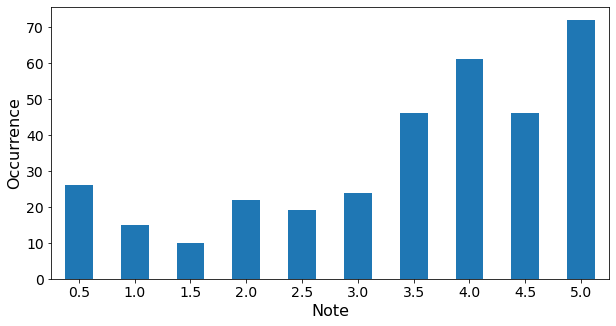

In [ ]:
plt.figure(figsize=(10,5))
df['Note'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Note', fontsize=16)
plt.ylabel('Occurrence', fontsize=16)
plt.show()

## Nb mots, Tok, stemm et stop words

In [ ]:
df['nb_mot'] = df['Description'].apply(lambda x: len(x.split()))
df['nb_phrase'] =df['Description'].apply(lambda x: len(x.split('. ')))
df['nb_caractere'] = df['Description'].apply(lambda x: len(x) - len(x.split())- len(x.split('.')))

df['description_clean'] = df['Description'].copy()
df['description_clean'] = df['description_clean'].map(lambda x : re.sub('[,\.!?()"]', '', x))
df['description_clean'] = df['description_clean'].map(lambda x : re.sub('\d', '', x))


df['tokens'] = df['description_clean'].apply(lambda x: word_tokenize(x))

snow_stemmer = SnowballStemmer(language='french')

french_stopwords = stopwords.words('french')
stop_words_fr_without_negation = [i for i in french_stopwords if i not in ['ne', 'pas', 'mais']]

df['stop_words'] = df['tokens'].apply(lambda x:[item for item in x if item not in stop_words_fr_without_negation])

df['stemm'] = df['stop_words'].apply(lambda x:[snow_stemmer.stem(item) for item in x])

In [ ]:
df.head(10)
df_class = df.copy() # copie pour travailler avec le Naive Bayes sur les notes 

## Sentiments

In [ ]:
df['Sentiment'] = df['Note'].apply(lambda x: 0 if x<4 else 1)

In [ ]:
df_y = df['Sentiment']

In [ ]:
df.drop('Sentiment', axis=1, inplace = True)

In [ ]:
df.drop('Note', axis=1, inplace = True)

In [ ]:
df.head()

,Description,good,bad,datetime,nb_mot,nb_phrase,nb_caractere,description_clean,tokens,stop_words,stemm
0,"On s'attendait à une fin plus élaborée, claire...",22,10,2021-10-02,562,14,2665,On s'attendait à une fin plus élaborée clairem...,"[On, s'attendait, à, une, fin, plus, élaborée,...","[On, s'attendait, fin, plus, élaborée, clairem...","[on, s'attend, fin, plus, élabor, clair, de, d..."
1,Encore une série très sur-côtée ! Tout est pré...,24,12,2021-10-01,89,3,402,Encore une série très sur-côtée Tout est prév...,"[Encore, une, série, très, sur-côtée, Tout, es...","[Encore, série, très, sur-côtée, Tout, prévisi...","[encor, ser, tres, sur-côt, tout, prévisibl, p..."
2,Pas fan des séries coréennes en général. Je do...,20,21,2021-09-22,30,4,151,Pas fan des séries coréennes en général Je doi...,"[Pas, fan, des, séries, coréennes, en, général...","[Pas, fan, séries, coréennes, général, Je, doi...","[pas, fan, ser, coréen, général, je, dois, avo..."
3,"Disons le tout de suite, je suis fan depuis 30...",9,10,2021-10-05,136,6,656,Disons le tout de suite je suis fan depuis an...,"[Disons, le, tout, de, suite, je, suis, fan, d...","[Disons, tout, suite, fan, depuis, ans, produc...","[dison, tout, suit, fan, depuis, an, product, ..."
4,"Visuellement recherché, très ludique, rythmé e...",7,9,2021-09-25,30,2,167,Visuellement recherché très ludique rythmé et ...,"[Visuellement, recherché, très, ludique, rythm...","[Visuellement, recherché, très, ludique, rythm...","[visuel, recherch, tres, ludiqu, rythm, galer,..."


## Train/Test split

Doc : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['stemm'],df_y, test_size=0.3, random_state=27)

In [ ]:
Y_train.value_counts()

1    124
0    114
Name: Sentiment, dtype: int64

In [ ]:
Y_test.value_counts()

1    55
0    48
Name: Sentiment, dtype: int64

In [ ]:
X_test

195    [pas, déplais, regard, mais, d'énorm, ficel, s...
236    [j'ai, pass, bon, moment, dev, squid, gam, déc...
21     [décor, imag, sublim, melang, battl, royal, se...
325    [on, a, toujour, droit, sempiternel, pseudo-ex...
216    [malgr, l'engou, international, cet, ser, ne, ...
                             ...                        
29     [vrai, fan, film, cor, sud, excellent, thrille...
260    [ok, direct, artist, reuss, jeux, parfois, hal...
252    [excellent, ser, mérit, larg, battag, médiat, ...
208    [général, ne, absolu, pas, ser, survival, mais...
226    [👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍...
Name: stemm, Length: 103, dtype: object

# TF-IDF

Doc : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html?highlight=tf%20idf#sklearn.feature_extraction.text.TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform([" ".join(words) for words in X_train])
labels_X_tfidf = tfidf_vectorizer.get_feature_names_out()

X_test_tfidf = tfidf_vectorizer.transform([" ".join(words) for words in X_test])

In [ ]:
X_train_tfidf.shape

(238, 2961)

In [ ]:
df_tidf_train = pd.DataFrame(data=X_train_tfidf.toarray(), columns=labels_X_tfidf)

In [ ]:
df_tidf_train.head()

,abandon,abattr,abim,abord,about,abri,abscon,absenc,absolu,absten,absurd,acab,accentu,accept,acceptablej,acceptent,acces,accessibl,accessoir,accompagn,accord,account,accroch,accrochec,accroît,accueil,accumul,accé,accéler,acerb,achet,achev,acteur,acteurs,acteurspar,action,actionhttp,actor,actric,actuel,...,énorm,épargn,éperdu,épiderm,épiqu,épisod,épisodesemot,épisodessinon,épisodeun,épop,époqu,épouv,épreuv,éprouv,équilibr,équip,équit,état,étir,étofféefinal,étoil,éton,étouff,étrang,étrangl,étud,évacuent,éven,éventuel,évid,évident,évit,évolu,êre,êtr,être,île,œil,œuvr,œuvresc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.081254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_tidf_train['sentiment'] = Y_train

In [ ]:
df_best_word = df_tidf_train.groupby(['sentiment']).sum()

In [ ]:
df_best_word_transposed = df_best_word.T

In [ ]:
df_best_word_transposed.head()

sentiment,0.0,1.0
abandon,0.000000,0.117309
abattr,0.101181,0.000000
abim,0.000000,0.179733
abord,0.301431,0.248846
about,0.036682,0.000000


In [ ]:
df_best_word_transposed.describe()

sentiment,0.0,1.0
count,2961.000000,2961.000000
mean,0.173746,0.187096
std,0.336444,0.394440
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.065874,0.081791
75%,0.209765,0.221598
max,5.240282,6.031960


In [ ]:
word_neg = df_best_word_transposed.iloc[:,0].sort_values(ascending=False).head(100)

In [ ]:
word_pos = df_best_word_transposed.iloc[:,1].sort_values(ascending=False).head(100)

In [ ]:
word_tri = [word for word in word_neg.index if word not in word_pos.index]

In [ ]:
X_test.head()

195    [pas, déplais, regard, mais, d'énorm, ficel, s...
236    [j'ai, pass, bon, moment, dev, squid, gam, déc...
21     [décor, imag, sublim, melang, battl, royal, se...
325    [on, a, toujour, droit, sempiternel, pseudo-ex...
216    [malgr, l'engou, international, cet, ser, ne, ...
Name: stemm, dtype: object

In [ ]:
y_test_predict = X_test.apply(lambda x: 0 if any(e in x for e in word_tri) else 1)

In [ ]:
confusion_matrix(Y_test, y_test_predict)

array([[42,  6],
       [44, 11]])

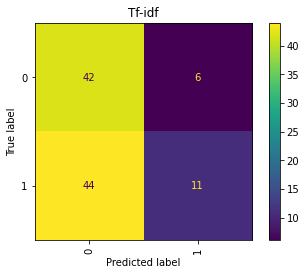

In [ ]:
cm = confusion_matrix(Y_test, y_test_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.title('Tf-idf')
plt.show()



---

On constate que notre modèle n'est pas fou, nous ne sommes pas loin de proba similaire à un lancer de pièce.

# Naive Bayes sur une cible binaire

Doc : https://scikit-learn.org/stable/modules/naive_bayes.html

## CountVectorize

Doc : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(df['stemm'],df_y, test_size=0.3, random_state=27)

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform([" ".join(words) for words in X_train2])
X2 = vectorizer.transform([" ".join(words) for words in X_test2]) 
vectorizer.get_feature_names_out()

array(['abandon', 'abattr', 'abim', ..., 'œil', 'œuvr', 'œuvresc'],
      dtype=object)

# BernoulliNB

Doc : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html

In [ ]:
clfb = BernoulliNB()
clfb.fit(X, Y_train2)

print(clfb.predict(X2))

[1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0
 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1]


In [ ]:
ypred = clfb.predict(X2)

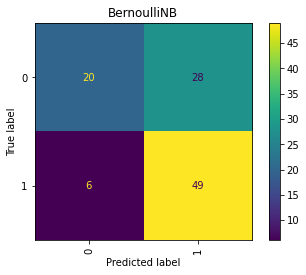

In [ ]:
cm = confusion_matrix(Y_test2, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.title('BernoulliNB')
plt.show()

In [ ]:
metrics.accuracy_score(Y_test2, ypred)

0.6699029126213593



---


Ce modèle n'est toujours pas satisfaisant, on remarque qu'il s'en sort mieux pour prédire des positifs (sentiment = 1)

# MultinomialNB

Doc : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [ ]:
clfm = MultinomialNB()
clfm.fit(X, Y_train2)

print(clfm.predict(X2))

[0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0
 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0
 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1]


In [ ]:
ypred2 = clfm.predict(X2)

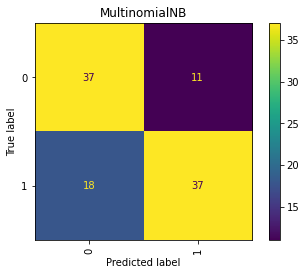

In [ ]:
cm = confusion_matrix(Y_test2, ypred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.title('MultinomialNB')
plt.show()

In [ ]:
metrics.accuracy_score(Y_test2, ypred2)

0.7184466019417476



---

Ce modèle semble plus acceptable comparé aux autres, il se trompe moins sur les positifs ou négatifs.

# GaussianNB

Doc : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [ ]:
clfg = GaussianNB()
clfg.fit(X.toarray(), Y_train2)

GaussianNB()

In [ ]:
ypred3 = clfg.predict(X2.toarray())

In [ ]:
X.shape

(238, 2961)

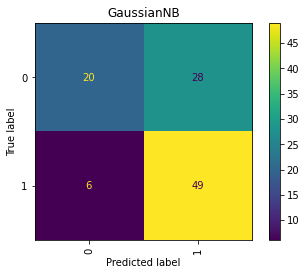

In [ ]:
cm = confusion_matrix(Y_test2, ypred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.title('GaussianNB')
plt.show()

In [ ]:
metrics.accuracy_score(Y_test2, ypred)

0.6699029126213593



---
J'ai du faire une erreur sur ce modèle, nous obtenons les mêmes résultats que pour le Bernoulli.


# Naive Bayes sur les notes





Nous avons précedement appliqué Naive Bayes sur une cible binaire, les sentiments "0" et "1", nous allons maintenant tenter de l'appliquer sur les notes avec trois classes : "0-2" , "3-4" et ">4".

## Préparation

In [ ]:
df_note = df_class[['Note','stemm']]

In [ ]:
df_note['Classification'] = df_note['Note'].apply(lambda x: '0-2' if x<3 else '3-4' if x<=4 else '5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_note.drop('Note', axis=1, inplace = True)

#df_note.set_index('Classification', inplace = True, drop=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_note.head()

,stemm,Classification
0,"[on, s'attend, fin, plus, élabor, clair, de, d...",3-4
1,"[encor, ser, tres, sur-côt, tout, prévisibl, p...",0-2
2,"[pas, fan, ser, coréen, général, je, dois, avo...",5
3,"[dison, tout, suit, fan, depuis, an, product, ...",5
4,"[visuel, recherch, tres, ludiqu, rythm, galer,...",3-4


In [ ]:
#df_note_group = df_note.groupby('Classification').sum()

In [ ]:
df_y2 = df_note['Classification']

# Train / test split

In [ ]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(df_note['stemm'],df_y2, test_size=0.3, random_state=20)

# Countvectorize

In [ ]:
vectorizer = CountVectorizer()

X3 = vectorizer.fit_transform([" ".join(words) for words in X_train3])
X4 = vectorizer.transform([" ".join(words) for words in X_test3]) 

vectorizer.get_feature_names_out()

array(['abattr', 'abdul', 'abim', ..., 'œil', 'œuvr', 'œuvresc'],
      dtype=object)

# BernoulliNB sur les notes

In [ ]:
clfb = BernoulliNB()
clfb.fit(X3, Y_train3)

print(clfb.predict(X4))

['5' '5' '5' '3-4' '3-4' '5' '0-2' '3-4' '3-4' '5' '5' '3-4' '5' '3-4' '5'
 '5' '3-4' '5' '5' '5' '0-2' '5' '3-4' '3-4' '5' '5' '5' '5' '5' '3-4'
 '0-2' '0-2' '5' '5' '3-4' '5' '3-4' '3-4' '5' '3-4' '5' '5' '3-4' '5'
 '3-4' '5' '5' '5' '5' '5' '3-4' '5' '5' '0-2' '5' '5' '3-4' '5' '3-4'
 '0-2' '5' '5' '5' '3-4' '3-4' '3-4' '3-4' '0-2' '5' '3-4' '3-4' '3-4' '5'
 '3-4' '5' '5' '3-4' '5' '3-4' '5' '5' '5' '5' '5' '3-4' '3-4' '5' '3-4'
 '5' '5' '5' '5' '3-4' '0-2' '3-4' '3-4' '3-4' '5' '3-4' '5' '5' '5' '0-2']


In [ ]:
ypred4 = clfb.predict(X4)

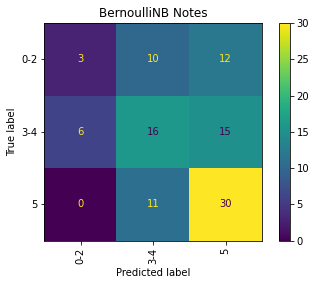

In [ ]:
cm = confusion_matrix(Y_test3, ypred4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0-2', '3-4', '5'])
disp.plot(xticks_rotation='vertical')
plt.title('BernoulliNB Notes')
plt.show()

In [ ]:
metrics.accuracy_score(Y_test3, ypred4)

0.47572815533980584

# MultinomialNB sur les notes

In [ ]:
clfmn = MultinomialNB()
clfmn.fit(X3, Y_train3)

print(clfmn.predict(X4))

['5' '0-2' '3-4' '3-4' '3-4' '3-4' '0-2' '3-4' '3-4' '3-4' '0-2' '3-4'
 '0-2' '3-4' '3-4' '3-4' '0-2' '5' '5' '0-2' '0-2' '5' '3-4' '3-4' '0-2'
 '0-2' '3-4' '3-4' '5' '3-4' '3-4' '3-4' '5' '0-2' '3-4' '0-2' '0-2' '3-4'
 '3-4' '0-2' '5' '5' '3-4' '3-4' '3-4' '0-2' '5' '5' '5' '5' '3-4' '5'
 '3-4' '3-4' '3-4' '5' '3-4' '3-4' '3-4' '0-2' '5' '3-4' '0-2' '3-4' '3-4'
 '3-4' '3-4' '0-2' '0-2' '3-4' '0-2' '3-4' '5' '0-2' '0-2' '5' '3-4' '3-4'
 '3-4' '5' '5' '5' '3-4' '0-2' '0-2' '3-4' '5' '0-2' '0-2' '3-4' '0-2'
 '3-4' '3-4' '0-2' '3-4' '3-4' '3-4' '5' '3-4' '0-2' '5' '5' '0-2']


In [ ]:
ypred5 = clfmn.predict(X4)

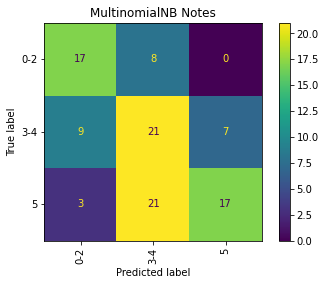

In [ ]:
cm = confusion_matrix(Y_test3, ypred5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0-2', '3-4', '5'])
disp.plot(xticks_rotation='vertical')
plt.title('MultinomialNB Notes')
plt.show()

In [ ]:
metrics.accuracy_score(Y_test3, ypred4)

0.47572815533980584

# GaussianNB sur les notes

In [ ]:
clfgn = GaussianNB()
clfgn.fit(X3.toarray(), Y_train3)

print(clfgn.predict(X4.toarray()))

['0-2' '3-4' '0-2' '3-4' '3-4' '3-4' '0-2' '3-4' '3-4' '3-4' '0-2' '0-2'
 '0-2' '3-4' '3-4' '5' '0-2' '5' '0-2' '3-4' '0-2' '5' '3-4' '3-4' '3-4'
 '0-2' '3-4' '3-4' '3-4' '3-4' '3-4' '3-4' '5' '3-4' '3-4' '0-2' '3-4'
 '3-4' '3-4' '0-2' '3-4' '5' '3-4' '5' '3-4' '0-2' '5' '5' '5' '0-2' '3-4'
 '5' '5' '3-4' '3-4' '5' '0-2' '5' '3-4' '0-2' '0-2' '3-4' '0-2' '3-4'
 '3-4' '3-4' '3-4' '0-2' '0-2' '3-4' '3-4' '3-4' '3-4' '0-2' '3-4' '5'
 '3-4' '5' '3-4' '3-4' '5' '5' '5' '5' '0-2' '3-4' '5' '3-4' '0-2' '5'
 '3-4' '3-4' '3-4' '0-2' '3-4' '3-4' '0-2' '5' '3-4' '3-4' '3-4' '3-4'
 '3-4']


In [ ]:
ypred6 = clfgn.predict(X4.toarray())

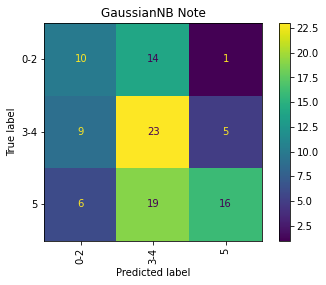

In [ ]:
cm = confusion_matrix(Y_test3, ypred6)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0-2', '3-4', '5'])
disp.plot(xticks_rotation='vertical')
plt.title('GaussianNB Note')
plt.show()

In [ ]:
metrics.accuracy_score(Y_test3, ypred6)

0.47572815533980584

In [ ]:
df_note.Classification.value_counts()

3-4    131
5      118
0-2     92
Name: Classification, dtype: int64

En conclusion, on remarque que plus il y a de classe, plus le modèle est mauvais, il faudra donc partir sur un modèle plus pertinant pour améliorer les résultats.